In [1]:
# import the necessary packages
import config
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

In [2]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
ANNOT_PATH = config.ANNOTS_PATH

[INFO] loading dataset...


In [3]:
ANNOTS = pd.read_csv(ANNOT_PATH, index_col=0)
ANNOTS['filename'] = ANNOTS['filename'].astype('string')

In [4]:
#ANNOTS.dtypes
ANNOTS['img_filename'] = ANNOTS.filename.str.split(pat='.',n = 1, expand = True)[0]

In [5]:
ANNOTS['img_filename'] = ANNOTS['img_filename']+'.jpg'

In [6]:
ANNOTS.dtypes

filename        string
startX           int64
startY           int64
endX             int64
endY             int64
class           object
img_filename    string
dtype: object

In [7]:
config.IMAGE_PATH

'../data/ucf_action/Running\\001'

In [8]:
# derive the path to the input image, load the image (in OpenCV
# format), and grab its dimensions
imagePath =config.IMAGE_PATH + '/' + ANNOTS.img_filename
data = []
for path in imagePath:
    image = cv2.imread(imagePath[1])
    (h, w) = image.shape[:2]
    # scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
    startX = ANNOTS['startX'].astype(float) / w
    startY = ANNOTS['startY'].astype(float) / h
    endX = ANNOTS['endX'].astype(float) / w
    endY = ANNOTS['endY'].astype(float) / h

    img_cord = {'startX': startX, 'startY': startY, 'endX': endX, 'endY': endY}
    img_cord_df = pd.DataFrame(img_cord)
    # load the image and preprocess it
    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image)
    # update our list of data, targets, and filenames
    data.append(image)




In [9]:
# converting dataframe img_cord_df to list

targets = img_cord_df.values.tolist()

In [10]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")


In [11]:
filenames = ANNOTS.img_filename.tolist()

In [12]:
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(config.TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [13]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [15]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=config.INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	verbose=1)

[INFO] training bounding box regressor...
Epoch 1/25
24/24 [==============================] - 14s 211ms/step - loss: 0.0203 - val_loss: 0.0056
Epoch 2/25
24/24 [==============================] - 2s 100ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 3/25
24/24 [==============================] - 2s 100ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/25
24/24 [==============================] - 2s 100ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 5/25
24/24 [==============================] - 2s 100ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 6/25
24/24 [==============================] - 2s 101ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 7/25
24/24 [==============================] - 2s 101ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 8/25
24/24 [==============================] - 2s 101ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 9/25
24/24 [==============================] - 2s 101ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 10/25
24/24 [==============================] - 2s 1

[INFO] saving object detector model...


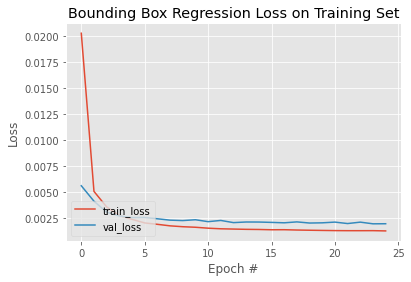

In [17]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.MODEL_PATH, save_format="h5")
# plot the model training history
N = config.NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)